# Challenge

## Download and install Spark

In [1]:
!ls

sample_data


In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,428 kB]
Hit:12 http://ppa.launchpad.net

## Setup environment

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [4]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2021-09-09 07:32:35--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [   <=>              ]   1.62G  3.14MB/s    in 11m 0s  

2021-09-09 07:43:36 (2.52 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1744843594]

total 1924556
-rw-r--r--  1 root root 1744843594 Sep  8 11:14 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x  1 root root       4096 Sep  1 19:26  sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018  spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018  spark-2.3.1-bin-hadoop2.7.tgz


In [5]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 1924556
-rw-r--r--  1 root root 1744843594 Sep  8 11:14 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Sep  1 19:26 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz


In [6]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [7]:
rc.cache()
rc.count()

6754608

In [8]:
rc.select('Primary type').distinct().count()

36

In [9]:
rc.select('Primary type').distinct().orderBy('Primary type').show(35, truncate=False)

+---------------------------------+
|Primary type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [10]:
nc = rc.filter((col('Primary type') == 'NON - CRIMINAL')|(col('Primary type') == 'NON-CRIMINAL')|(col('Primary type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDE

In [11]:
nc.groupBy('Description').count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



In [12]:
from pyspark.sql.functions import dayofweek

In [13]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [14]:
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [15]:
rc.select('Date', dayofweek('Date')).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2015-09-05 13:30:00|              7|
|2015-09-04 11:30:00|              6|
|2018-09-01 00:01:00|              7|
|2015-09-05 12:45:00|              7|
|2015-09-05 13:00:00|              7|
+-------------------+---------------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import date_format

In [17]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]
    
    .. versionadded:: 1.5



In [18]:
rc.select('Date', dayofweek('Date'), date_format('Date', 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [19]:
rc.groupBy(date_format('Date', 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017157|
|                 Wed| 974075|
|                 Tue| 968220|
|                 Sat| 965347|
|                 Thu| 964764|
|                 Mon| 952924|
|                 Sun| 912121|
+--------------------+-------+



**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [20]:
rc.groupBy(date_format('Date', 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912121),
 Row(date_format(Date, E)='Mon', count=952924),
 Row(date_format(Date, E)='Thu', count=964764),
 Row(date_format(Date, E)='Sat', count=965347),
 Row(date_format(Date, E)='Wed', count=974075),
 Row(date_format(Date, E)='Fri', count=1017157),
 Row(date_format(Date, E)='Tue', count=968220)]

In [23]:
day_of_week = [x[0] for x in rc.groupBy(date_format('Date', 'E')).count().collect()]
day_of_week

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [24]:
count = [x[1] for x in rc.groupBy(date_format('Date', 'E')).count().collect()]
count

[912121, 952924, 964764, 965347, 974075, 1017157, 968220]

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
cp = pd.DataFrame({'Day of week': day_of_week, 'Count':count})
cp.head(7)

,Day of week,Count
0,Sun,912121
1,Mon,952924
2,Thu,964764
3,Sat,965347
4,Wed,974075
5,Fri,1017157
6,Tue,968220


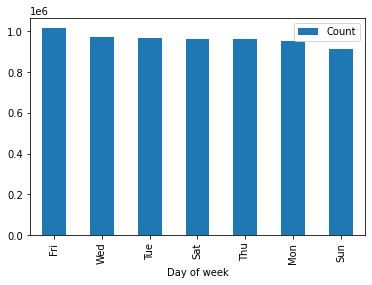

In [40]:
cp.sort_values('Count', ascending = False).plot(kind='bar', x='Day of week', y='Count')

Text(0.5, 1.0, 'Numer of reported crimes per day of week from 2001 to present')

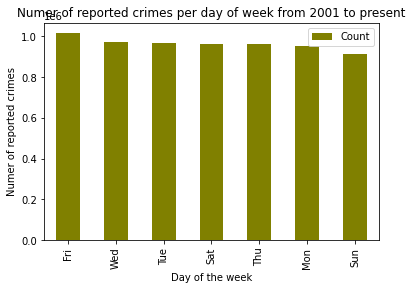

In [41]:
cp.sort_values('Count', ascending = False).plot(kind='bar', color = 'olive', x='Day of week', y='Count')
plt.xlabel('Day of the week')
plt.ylabel('Numer of reported crimes')
plt.title('Numer of reported crimes per day of week from 2001 to present')